In [1]:
import os,sys
import cPickle as pickle
import numpy as np                                       # fast vectors and matrices
import matplotlib.pyplot as plt                          # plotting
from scipy.fftpack import fft

from time import time

sys.path.insert(0,'lib/')
import config
import diagnostics
import base_model

from sklearn.metrics import average_precision_score

os.environ['CUDA_VISIBLE_DEVICES']=''

import tensorflow as tf

%matplotlib inline

In [2]:
with open(config.labels_path) as f:
    labels = pickle.load(f)

In [3]:
# filters between 10Hz and 22kHz
def create_filters(d,k):
    x = np.linspace(0, 2*np.pi, d, endpoint=False)
    wsin = np.empty((1,d,1,k), dtype=np.float32)
    wcos = np.empty((1,d,1,k), dtype=np.float32)
    start_freq = 50.
    end_freq = 6000.
    num_cycles = start_freq*d/44000.
    scaling_ind = (end_freq/start_freq)/k
    window_mask = 1.0#-1.0*np.cos(x)
    for ind in range(k):
        wsin[0,:,0,ind] = window_mask*np.sin((ind*scaling_ind)*num_cycles*x)
        wcos[0,:,0,ind] = window_mask*np.cos((ind*scaling_ind)*num_cycles*x)
            
    return wsin,wcos

class Spectrograms(base_model.Model):
    def __init__(self, *args, **kwargs):
        super(Spectrograms, self).__init__(*args, **kwargs)

    def define_graph(self):
        super(Spectrograms, self).define_graph()
        
        # lvl1 convolutions are shared between regions
        self.k = 512              # lvl1 nodes
        self.d = 4096              # lvl1 receptive field

        # number of lvl1 features
        regions = 1 + (self.window - self.d)/self.stride
        print 'Number of V1 feature regions: {}'.format(regions)

        # preconditionable weights
        wsin,wcos = create_filters(self.d,self.k)

        with tf.variable_scope('parameters'):
            beta = tf.Variable(tf.zeros([regions*self.k,self.m]))
            betaavg = self.register_weights(beta,'beta',average=.9998)

        with tf.variable_scope('queued_model'):
            zx = tf.square(tf.nn.conv2d(self.xq,wsin,strides=[1,1,self.stride,1],padding='VALID')) \
               + tf.square(tf.nn.conv2d(self.xq,wcos,strides=[1,1,self.stride,1],padding='VALID'))
            y = tf.matmul(tf.reshape(zx,[self.batch_size,regions*self.k]),beta)
            self.loss = tf.reduce_mean(tf.nn.l2_loss(y-tf.reshape(self.yq,[self.batch_size,self.m])))

        with tf.variable_scope('direct_model'):
            self.zx = tf.square(tf.nn.conv2d(self.xd,wsin,strides=[1,1,self.stride,1],padding='VALID')) \
                    + tf.square(tf.nn.conv2d(self.xd,wcos,strides=[1,1,self.stride,1],padding='VALID'))
            self.y_direct = tf.matmul(tf.reshape(self.zx,[tf.shape(self.xd)[0],regions*self.k]),betaavg)
            self.loss_direct = tf.reduce_mean(tf.nn.l2_loss(self.y_direct-self.yd))

In [4]:
try: model.stop()
except NameError: pass
model = Spectrograms(labels,checkpoint_path='spectrograms_stft_nocompress/', outputs=1, window=16384, mmap=True,
                    normalize=True, extended_test_set=True, use_mirex=False, init=False, pitch_transforms=5, jitter=.1,
                    restrict=False)

Number of V1 feature regions: 25


In [5]:
lr = .0000000001/2/2
#lr = .001/2
mom = .95

# stop the model if it is already running
model.stop()

# we have to rebuild the graph every time because input queues can't be reopened
model.define_graph()

learning_rate = tf.placeholder(tf.float32, shape=[])
opt_op = tf.train.MomentumOptimizer(learning_rate,mom).minimize(model.loss)
with tf.control_dependencies([opt_op]):
    train_step = tf.group(*model.averages)

# start up the session, kick off the worker threads, restore checkpoint, etc.
model.start()

try:
    ptime = time()
    print model.status_header()
    while True:
        if model.iter % 1000 == 0:
            model.update_status(ptime,time(),lr)
            model.checkpoint()
            print model.status()
            ptime = time()

        model.sess.run(train_step, feed_dict={learning_rate: lr})
        model.iter += 1

except KeyboardInterrupt:
    model.checkpoint()
    print 'Graceful Exit'

Number of V1 feature regions: 25
avp_test	avp_train	mse_test	mse_train	time	utime
0.395609        0.412915        0.855353        1.085121        77      77      
0.395602        0.412990        0.855311        1.085011        265     74      
Graceful Exit


0.39608686194
0.855259324004


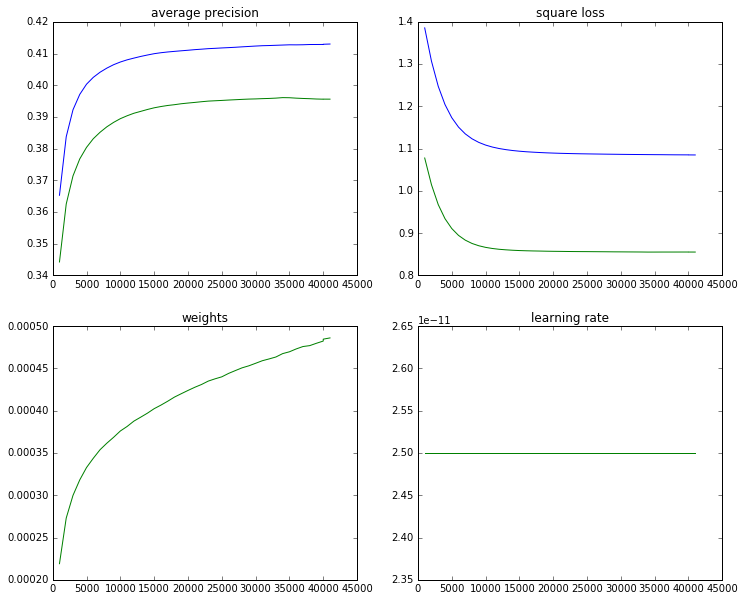

In [6]:
burnin=1
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2,2)
fig.set_figwidth(12)
fig.set_figheight(10)
ax1.set_title('average precision')
ax1.plot(model.stats['iter'][2][burnin:],model.stats['avp_test'][2][burnin:],color='g')
ax1.plot(model.stats['iter'][2][burnin:],model.stats['avp_train'][2][burnin:],color='b')
ax2.set_title('square loss')
ax2.plot(model.stats['iter'][2][burnin:],model.stats['mse_test'][2][burnin:],color='g')
ax2.plot(model.stats['iter'][2][burnin:],model.stats['mse_train'][2][burnin:],color='b')
ax3.set_title('weights')
ax3.plot(model.stats['iter'][2][burnin:],model.stats['nbeta'][2][burnin:],color='g')
ax4.set_title('learning rate')
ax4.plot(model.stats['iter'][2][burnin:],model.stats['lr'][2][burnin:],color='g')

print max(model.stats['avp_test'][2][burnin:])
print min(model.stats['mse_test'][2][burnin:])

# Mirex stats

In [7]:
mse_test, Yhat, Y, mse_breakdown, avp_breakdown = model.sample_records(config.test_ids, 7500, fixed_stride=512)
avp_test = average_precision_score(Y.flatten(),Yhat.flatten())
print avp_test

0.404754726515


In [8]:
Accavg = Etotavg = 0
for i in range(3):
    _,_,_,Acc,Etot = visuals.mirex_statistics(model,i,threshold=.4)
    Accavg += Acc
    Etotavg += Etot

print Accavg/3.,Etotavg/3.

AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
41.71	63.06	22.18	0.20	0.80	0.11	0.67	0.02
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
26.08	45.29	10.12	0.09	0.95	0.07	0.83	0.05
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
47.68	64.24	21.16	0.19	0.83	0.07	0.71	0.04
0.158590506342 0.860359774327


# Extended test set stats

In [7]:
mse_test, Yhat, Y, mse_breakdown, avp_breakdown = model.sample_records(config.test_ids_ext, 7500, fixed_stride=512)
avp_test = average_precision_score(Y.flatten(),Yhat.flatten())
print avp_test

0.404689218856


In [15]:
Accavg = Etotavg = 0
for i in range(10):
    _,_,_,Acc,Etot = diagnostics.mirex_statistics(model,i,threshold=.4)
    Accavg += Acc
    Etotavg += Etot

print Accavg/10.,Etotavg/10.

AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
41.75	63.06	22.18	0.20	0.80	0.11	0.67	0.02
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
26.16	45.09	10.12	0.09	0.95	0.07	0.83	0.05
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
47.70	63.96	21.19	0.19	0.83	0.07	0.71	0.04
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
31.72	34.74	31.58	0.20	0.90	0.38	0.31	0.22
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
44.54	54.91	30.48	0.24	0.78	0.16	0.53	0.09
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
45.55	67.25	18.61	0.17	0.83	0.08	0.74	0.01
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
40.71	54.03	29.58	0.24	0.84	0.11	0.59	0.14
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
44.91	65.45	18.29	0.17	0.85	0.06	0.75	0.03
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
47.26	64.15	16.07	0.15	0.86	0.07	0.77	0.02
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
35.24	50.46	11.62	0.10	0.90	0.10	0.78	0.01
0.174316824517 0.854800543932
